Running MCMC...


100%|██████████| 2000/2000 [02:50<00:00, 11.71it/s]


MCMC finished.
Optimized control point apparent magnitudes and their errors (m_B,b ± err):
z_b = 0.010, m_B,b = 13.883 ± 0.037
z_b = 0.012, m_B,b = 14.180 ± 0.042
z_b = 0.014, m_B,b = 14.604 ± 0.047
z_b = 0.016, m_B,b = 14.793 ± 0.050
z_b = 0.019, m_B,b = 15.289 ± 0.042
z_b = 0.022, m_B,b = 15.492 ± 0.030
z_b = 0.025, m_B,b = 15.880 ± 0.030
z_b = 0.030, m_B,b = 16.204 ± 0.025
z_b = 0.035, m_B,b = 16.606 ± 0.036
z_b = 0.040, m_B,b = 16.942 ± 0.032
z_b = 0.047, m_B,b = 17.240 ± 0.055
z_b = 0.055, m_B,b = 17.560 ± 0.082
z_b = 0.064, m_B,b = 17.859 ± 0.058
z_b = 0.075, m_B,b = 18.317 ± 0.034
z_b = 0.087, m_B,b = 18.661 ± 0.051
z_b = 0.102, m_B,b = 19.110 ± 0.041
z_b = 0.119, m_B,b = 19.280 ± 0.038
z_b = 0.139, m_B,b = 19.815 ± 0.029
z_b = 0.162, m_B,b = 20.005 ± 0.027
z_b = 0.190, m_B,b = 20.494 ± 0.021
z_b = 0.221, m_B,b = 20.824 ± 0.023
z_b = 0.259, m_B,b = 21.217 ± 0.020
z_b = 0.302, m_B,b = 21.622 ± 0.019
z_b = 0.352, m_B,b = 21.983 ± 0.020
z_b = 0.412, m_B,b = 22.396 ± 0.037
z_b = 0.4

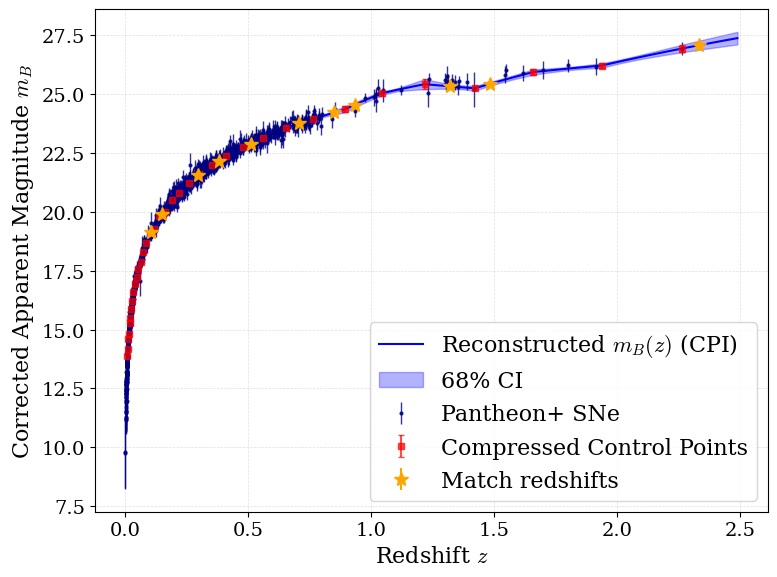

In [1]:
# Compressed ways
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import emcee
import matplotlib
import matplotlib.pyplot as plt

z_DV, DV_rd, DV_rd_err = np.loadtxt('Data/Combine_DV_rd.dat', unpack=True)
z_DM, DM_rd, DM_rd_err = np.loadtxt('Data/Combine_DM_rd.dat', unpack=True)
z_BAO = np.concatenate([z_DV, z_DM])

# extract data
data = pd.read_csv('Data/Pantheon+SH0ES.dat', sep=' ')
z_sn = data['zHD'].values
m_b = data['m_b_corr'].values
m_b_err = data['m_b_corr_err_DIAG'].values

# use full covariance if available
try:
    with open('Data/Pantheon+SH0ES_STAT+SYS.cov', 'r') as f:
        lines = f.readlines()
    N = int(lines[0].strip())
    cov_elements = np.array([float(x.strip()) for x in lines[1:]])
    cov_full = cov_elements.reshape((N, N))
    cov_inv = np.linalg.inv(cov_full)
except FileNotFoundError:
    cov_stat = np.diag(m_b_err**2)
    cov_inv = np.linalg.inv(cov_stat)
    print("Warning: Using diagonal errors only.")

# control points which is uniform in log space
z_b = np.logspace(np.log10(0.01), np.log10(max(z_sn)), 36)
ln_z_b = np.log(z_b)

# interpolation function for mB_bar
def compute_mB_bar(z, mB_b_values, z_b_points):
    """
    Calculate mB_bar value at given redshift z.
    mB_b_values: mB values at control points
    z_b_points: redshifts of control points
    """
    ln_z = np.log(z)
    # linear interpolation in log space
    interp_func = interp1d(np.log(z_b_points), mB_b_values, kind='linear', fill_value="extrapolate")
    return interp_func(ln_z)


# loglikihood
def ln_likelihood(mB_b, z_data, mB_data, cov_inv):
    mB_bar = compute_mB_bar(z_data, mB_b, z_b)
    delta = mB_data - mB_bar
    chi2 = delta.T @ cov_inv @ delta
    return -0.5 * chi2

# prior
def ln_prior(mB_b):
    # Assume mB_b is within a reasonable range, e.g., 10 to 30
    if np.all((10 < mB_b) & (mB_b < 30)):
        return 0.0
    return -np.inf

# posterior
def ln_posterior(mB_b, z_data, mB_data, cov_inv):
    lp = ln_prior(mB_b)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(mB_b, z_data, mB_data, cov_inv)

# --- MCMC ---
n_walkers = 72
n_dim = len(z_b)
mB_b_init = np.interp(z_b, z_sn, m_b) # Initial value based on data interpolation
np.random.seed(42)
initial = mB_b_init + 0.1 * np.random.randn(n_walkers, n_dim) # Add small perturbation


sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_posterior, args=(z_sn, m_b, cov_inv))
print("Running MCMC...")
sampler.run_mcmc(initial, 2000, progress=True)
print("MCMC finished.")

# --- Extract results ---
samples = sampler.get_chain(discard=200, flat=True) # Discard first 200 steps as burn-in
mB_b_opt = np.median(samples, axis=0) # Best fit value (median)
mB_b_err = np.percentile(samples, [16, 84], axis=0) # 1-sigma error
mB_b_err = np.diff(mB_b_err, axis=0)[0] / 2

# Output
print("Optimized control point apparent magnitudes and their errors (m_B,b ± err):")
for i, (z_val, mB_val, err) in enumerate(zip(z_b, mB_b_opt, mB_b_err)):
    print(f"z_b = {z_val:.3f}, m_B,b = {mB_val:.3f} ± {err:.3f}")

# BAO redshift interpolation
mB_bar_BAO = compute_mB_bar(z_BAO, mB_b_opt, z_b)
n_samples_for_err = 1000 # Number of MCMC samples for error calculation
# Randomly select n_samples_for_err MCMC samples
random_indices_for_err = np.random.choice(len(samples), n_samples_for_err, replace=False)
mB_bar_BAO_samples = np.array([compute_mB_bar(z_BAO, samples[i], z_b) for i in random_indices_for_err])
mB_bar_BAO_err = np.percentile(mB_bar_BAO_samples, [16, 84], axis=0)
mB_bar_BAO_err = np.diff(mB_bar_BAO_err, axis=0)[0] / 2
print("\nCompressed apparent magnitudes and their errors at BAO redshifts (m_B_bar ± err):")
for z_val, mB_val, err in zip(z_BAO, mB_bar_BAO, mB_bar_BAO_err):
    print(f"z = {z_val:.2f}, m_B_bar = {mB_val:.3f} ± {err:.3f}")

# Check error scaling
avg_points_per_bin = len(z_sn) / len(z_b)
expected_err_reduction = 1 / np.sqrt(avg_points_per_bin)
print(f"\nAverage number of data points per bin: {avg_points_per_bin:.1f}")
print(f"Expected error reduction factor: {expected_err_reduction:.3f}")

with open("Output/m_b_reconstruct_results.txt", "w") as file:
    file.write("# z_BAO, mB_bar_BAO, mB_bar_BAO_err\n")
    for z, m, m_err in zip(z_BAO, mB_bar_BAO, mB_bar_BAO_err):
        file.write(f"{z} {m} {m_err}\n")


# 1. Generate a dense redshift grid
# Range from minimum redshift (or close to 0) to maximum redshift (or slightly beyond)
z_plot = np.linspace(0.01, max(z_sn) * 1.1, 1000) # 500 points are smooth enough

# 2. Use optimized control point values to calculate smooth curve
mB_bar_plot = compute_mB_bar(z_plot, mB_b_opt, z_b)

# 3. Calculate error band for predicted curve
# Again randomly sample from MCMC samples to estimate error at each z_plot point
n_plot_samples = 1000 # Number of MCMC samples for error band plot
random_indices_plot = np.random.choice(len(samples), n_plot_samples, replace=False)
mB_bar_plot_samples = np.array([compute_mB_bar(z_plot, samples[i], z_b) for i in random_indices_plot])

# Calculate 1-sigma (68%) confidence interval
# mB_bar_plot_lower = np.percentile(mB_bar_plot_samples, 16, axis=0)
# mB_bar_plot_upper = np.percentile(mB_bar_plot_samples, 84, axis=0)

mB_bar_plot_std = np.std(mB_bar_plot_samples, axis=0)

np.savez('Output/cpi_mB_reconstruction_results.npz',
         z_pred_points=z_plot,
         mB_pred=mB_bar_plot,
         mB_std=mB_bar_plot_std,
         z_BAO=z_BAO,
         mB_match=mB_bar_BAO,
         mB_match_err=mB_bar_BAO_err)

# --- draw plot ---
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'font.size': 14
})

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(z_plot, mB_bar_plot, label=r'Reconstructed $m_B(z)$ (CPI)', color='blue')

# Plot data from different sources
ax.errorbar(z_sn, m_b, m_b_err, fmt='o', label='Pantheon+ SNe',
            capsize=0, ms=2, elinewidth=1, color='navy', alpha=0.8)

ax.errorbar(z_b, mB_b_opt, mB_b_err, fmt='s', label='Compressed Control Points',
            color='red', alpha=0.7, markersize=4, capsize=2, linestyle='none')

ax.errorbar(z_BAO, mB_bar_BAO, mB_bar_BAO_err, fmt='*', label='Match redshifts',
            markersize=10, linestyle='none', color='orange') 


ax.fill_between(z_plot, mB_bar_plot - mB_bar_plot_std, mB_bar_plot + mB_bar_plot_std, color='blue', alpha=0.3, label=r'68% CI')

ax.set_xlabel(r'Redshift $z$', fontsize=16)
ax.set_ylabel(r'Corrected Apparent Magnitude $m_B$', fontsize=16)

ax.legend(loc='best', frameon=True, fontsize=16)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.savefig('fig/mB_reconstruction(CPI).pdf', bbox_inches='tight')
plt.show()


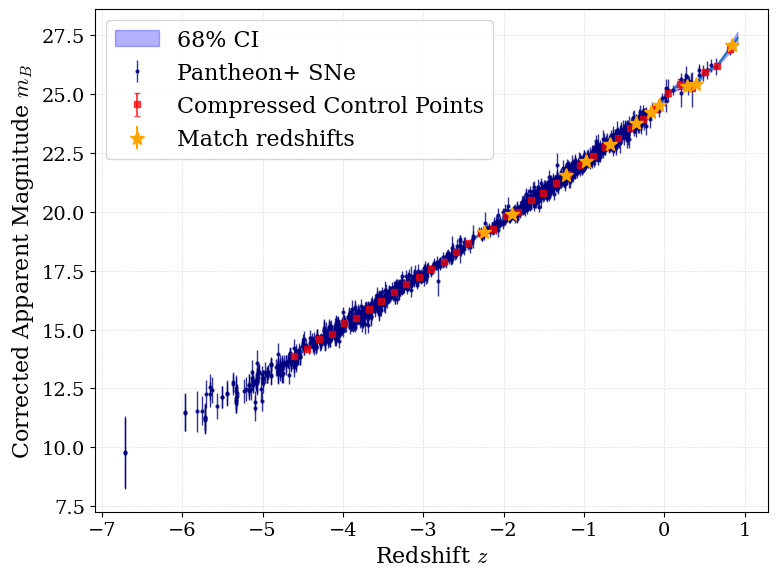

In [2]:
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'font.size': 14
})

fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(np.log(z_sn), m_b, m_b_err, fmt='o', label='Pantheon+ SNe',
            capsize=0, ms=2, elinewidth=1, color='navy', alpha=0.8)

ax.errorbar(np.log(z_b), mB_b_opt, mB_b_err, fmt='s', label='Compressed Control Points',
            color='red', alpha=0.7, markersize=4, capsize=2, linestyle='none')

ax.errorbar(np.log(z_BAO), mB_bar_BAO, mB_bar_BAO_err, fmt='*', label='Match redshifts',
            markersize=10, linestyle='none', color='orange')

ax.plot(np.log(z_plot), mB_bar_plot)

ax.fill_between(np.log(z_plot), mB_bar_plot - mB_bar_plot_std, mB_bar_plot + mB_bar_plot_std, color='blue', alpha=0.3, label=r'68% CI')

ax.set_xlabel(r'Redshift $z$', fontsize=16)
ax.set_ylabel(r'Corrected Apparent Magnitude $m_B$', fontsize=16)

ax.legend(loc='best', frameon=True, fontsize=16)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.show()

Optimized Kernel: FullCovarianceKernel(6.91, 3.32)
GPR mB reconstruction results saved to 'Output/gpr_mB_reconstruction_results.npz'


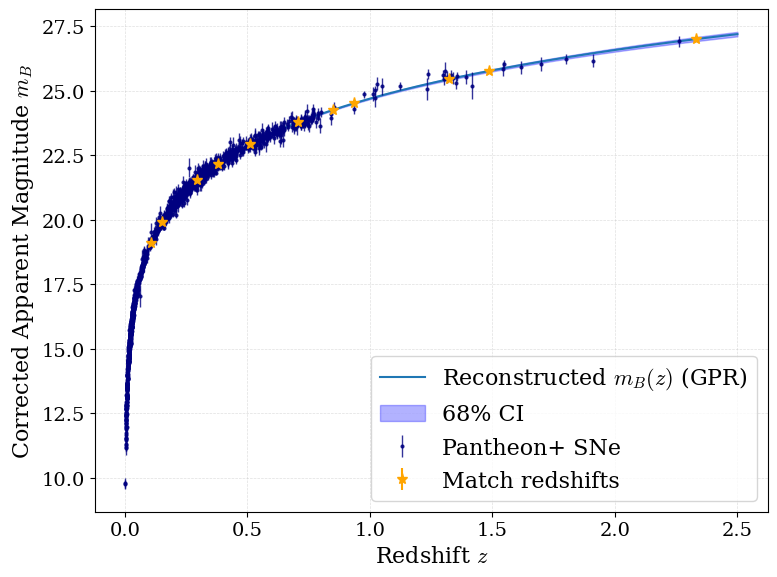

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, Matern, ConstantKernel as C

z_DV, DV_rd, DV_rd_err = np.loadtxt('Data/Combine_DV_rd.dat', unpack=True)
z_DM, DM_rd, DM_rd_err = np.loadtxt('Data/Combine_DM_rd.dat', unpack=True)
z_BAO = np.concatenate([z_DV, z_DM])

data = pd.read_csv('Data/Pantheon+SH0ES.dat', sep=' ')
z_sn = data['zHD'].values
m_b = data['m_b_corr'].values

with open('Data/Pantheon+SH0ES_STAT+SYS.cov', 'r') as f:
    lines = f.readlines()
N = int(lines[0].strip())
cov_elements = np.array([float(x.strip()) for x in lines[1:]])
cov_full = cov_elements.reshape((N, N))

class FullCovarianceKernel(Kernel):
    def __init__(self, signal_kernel, noise_cov):
        self.signal_kernel = signal_kernel
        self.noise_cov = noise_cov

    def __call__(self, X, Y=None, eval_gradient=False):

        if eval_gradient:
            K_signal, K_grad = self.signal_kernel(X, Y, eval_gradient=True)
            # 只有在计算训练数据的自协方差 K(X, X) 时才加上 C_noise
            if Y is None:
                return K_signal + self.noise_cov, K_grad
            else:
                return K_signal, K_grad
        else:
            K_signal = self.signal_kernel(X, Y, eval_gradient=False)
            # 同样，只有在计算 K(X, X) 时才加上 C_noise
            if Y is None:
                return K_signal + self.noise_cov
            else:
                return K_signal

    @property
    def theta(self):
        return self.signal_kernel.theta

    @theta.setter
    def theta(self, value):
        self.signal_kernel.theta = value

    @property
    def bounds(self):
        return self.signal_kernel.bounds

    def get_params(self, deep=True):
        return {"signal_kernel": self.signal_kernel, "noise_cov": self.noise_cov}

    def is_stationary(self):
        return self.signal_kernel.is_stationary()

    def diag(self, X):
        return self.signal_kernel.diag(X)



log_z_sn = np.log(z_sn).reshape(-1, 1)
log_z_BAO = np.log(z_BAO).reshape(-1, 1)
z_pred_points = np.linspace(0.01, 2.5, 1000)
log_z_pred_points = np.log(z_pred_points).reshape(-1, 1)

initial_amplitude = np.var(m_b)
signal_kernel = C(initial_amplitude, (1e-3, 1e3)) * Matern(length_scale=0.1, length_scale_bounds=(1e-2, 1e2), nu=2.5)

full_kernel = FullCovarianceKernel(signal_kernel, cov_full)

gpr = GaussianProcessRegressor(kernel=full_kernel, alpha=1e-6, normalize_y=False)

gpr.fit(log_z_sn, m_b)

print("Optimized Kernel:", gpr.kernel_)

mB_pred, mB_std = gpr.predict(log_z_pred_points, return_std=True)
mB_match, mB_match_err = gpr.predict(log_z_BAO, return_std=True)

np.savez('Output/gpr_mB_reconstruction_results.npz',
         z_pred_points=z_pred_points,
         mB_pred=mB_pred,
         mB_std=mB_std,
         z_BAO=z_BAO,
         mB_match=mB_match,
         mB_match_err=mB_match_err)
print("GPR mB reconstruction results saved to 'Output/gpr_mB_reconstruction_results.npz'")

plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'font.size': 14
})

plt.figure(figsize=(8, 6))
ax = plt.gca()
plt.plot(z_pred_points, mB_pred, label='Reconstructed $m_B(z)$ (GPR)')
plt.fill_between(z_pred_points, mB_pred - mB_std, mB_pred + mB_std,
                 color='blue', alpha=0.3, label='68% CI')

plt.errorbar(z_sn, m_b, yerr=np.sqrt(np.diag(cov_full)), fmt='o', label='Pantheon+ SNe',
             capsize=0, ms=2, elinewidth=1, color='navy', alpha=0.8)

plt.errorbar(z_BAO, mB_match, mB_match_err, markersize=8, fmt='*',
             label='Match redshifts', color='orange', zorder=10)

plt.xlabel('Redshift $z$', fontsize=16)
ax.set_ylabel(r'Corrected Apparent Magnitude $m_B$', fontsize=16)
ax.legend(loc='best', frameon=True, fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.savefig('fig/mB_reconstruction(GPR).pdf', bbox_inches='tight')
plt.show()

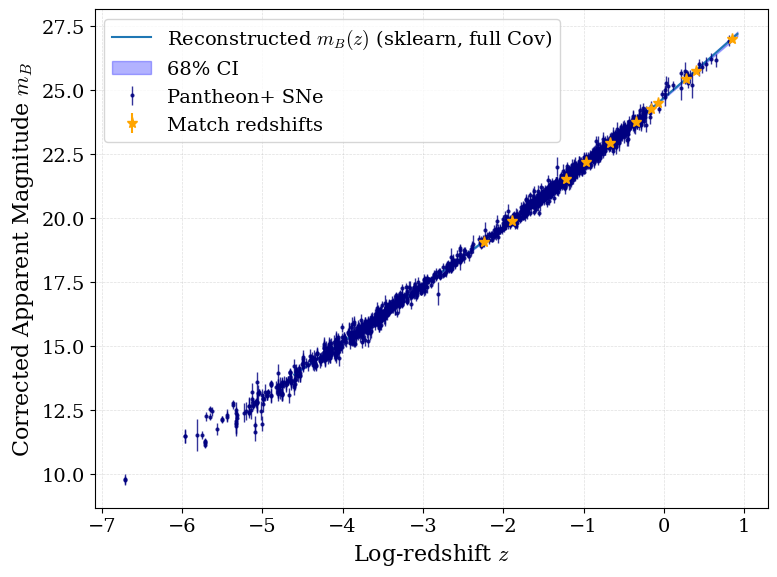

In [4]:
plt.figure(figsize=(8, 6))
ax = plt.gca()
plt.plot(np.log(z_pred_points), mB_pred, label='Reconstructed $m_B(z)$ (sklearn, full Cov)')
plt.fill_between(np.log(z_pred_points), mB_pred - mB_std, mB_pred + mB_std,
                 color='blue', alpha=0.3, label='68% CI')

plt.errorbar(np.log(z_sn), m_b, yerr=np.sqrt(np.diag(cov_full)), fmt='o', label='Pantheon+ SNe',
             capsize=0, ms=2, elinewidth=1, color='navy', alpha=0.8)

plt.errorbar(np.log(z_BAO), mB_match, mB_match_err, markersize=8, fmt='*',
             label='Match redshifts', color='orange', zorder=10)

plt.xlabel('Log-redshift $z$', fontsize=16)
ax.set_ylabel(r'Corrected Apparent Magnitude $m_B$', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
# plt.savefig('fig/mB_reconstruction(sklearn_full_cov).pdf', bbox_inches='tight')
plt.show()